In [1]:
# Импортируем библиотеки

import pandas as pd
import pandahouse as ph
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Вытаскиваем данные из clickhouse для групп 1 и 2 в период с 2023-01-31 по 2023-02-06

connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230220',
              'user':'student', 
              'password':'dpo_python_2020'
              }

query = '''
select exp_group,
       user_id,
       sum(action='like') likes,
       sum(action='view') views,
       likes/views ctr
from {db}.feed_actions 
where toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06'
      and exp_group in (1, 2)
group by exp_group,
       user_id
'''

df = ph.read_clickhouse(query, connection=connection)

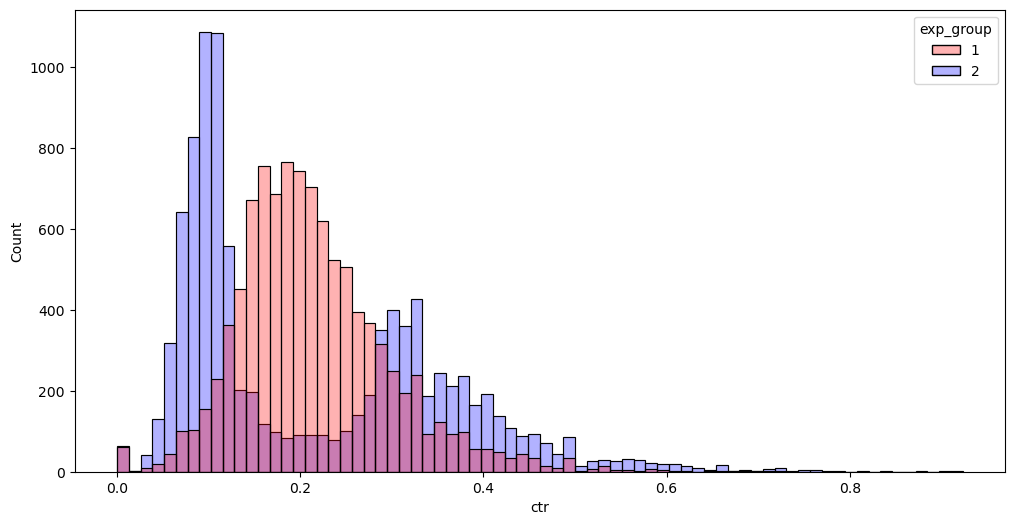

In [3]:
# Рисуем гистограмму распределения поюзерных ctr

plt.figure(figsize=(12, 6))
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.3,
              kde=False)

In [4]:
df[df.exp_group == 1].ctr.mean()

0.21560459841296403

In [5]:
df[df.exp_group == 2].ctr.mean()

0.21441927347479056

In [6]:
# Проводим t-тест
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

In [7]:
# Проводим тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [8]:
# Проводим t-тест в clickhouse для групп 1 и 2 в период с 2023-01-31 по 2023-02-06

connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230220',
              'user':'student', 
              'password':'dpo_python_2020'
              }

query = '''
WITH welchTTest(ctr, exp_index) as ttest

select tupleElement(ttest,1) as statistic,
    tupleElement(ttest,2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 1 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-01-31' and '2023-02-06'
        and exp_group in (1, 2)
    GROUP BY exp_group, user_id)
'''

ph.read_clickhouse(query, connection=connection)

,statistic,p_value
0,0.709439,0.478062


In [9]:
# Проводим t-тест в clickhouse для групп 1 и 2 в период с 2023-01-31 по 2023-02-06

connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230220',
              'user':'student', 
              'password':'dpo_python_2020'
              }

query = '''
WITH mannWhitneyUTest('two-sided')(ctr, exp_index) as ttest

select tupleElement(ttest,1) as statistic,
    tupleElement(ttest,2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 1 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-01-31' and '2023-02-06'
        and exp_group in (1, 2)
    GROUP BY exp_group, user_id)
'''

ph.read_clickhouse(query, connection=connection)

,statistic,p_value
0,56601260.5,1.655343e-13
